# PythonDataIES project - bezrealitky.cz
Authors: Tiep Luu Danh, Jan Malecha

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import pandas as pd
import tqdm as tqdm
from lxml import html
import time
import itertools

## Bezrealitky pages class structure

**Estate (parent)** - class containing general methods for parsing bezrealitky websites
 - **Flat (child)** - standard properties, no special naming of methods as it type of majority of observations
 - **NBFlat (child)** - new-build properties, a group of new build estates that have very different page, methods for this class end with NB

In [7]:
class Estate:
    '''
    Defined as parent class for all possible version of bezrealitky pages
    
    Containing general methods used in scraping these websites
    '''
    def __init__(self, link):
        self.link = link
        self.soup = self.getSoup
        
    def getSoup(self):
        '''
        Initialize soup object.
        '''
        r = requests.get(self.link)
        r.encoding = 'UTF-8'
        
        return BeautifulSoup(r.text, 'html')   

In [140]:
class Flat(Estate):
    def __init__(self, link):
        '''
        Constructor for Flat calls parents Estate constructor first,
        where self.link and self.soup are created
        
        Then flat parameters and coordinates are generated as Flat attributes
        '''
        # Calling Estate constructor
        super().__init__(link)
        
        # getting soup
        self.soup = self.getSoup()
        
        # Getting paramaters of flat
        self.parameters = self.getParameters()
        
        # Getting coordinates of flat
        self.coordinates = self.getMap()
        
        # Getting resulting dataframe
        self.df = self.getDf()
        
    def getParameters(self):
        '''
        Get parameters of given estate - such as price, disposition, the state of the house, etc.
        '''
        bf_table = self.soup.find('div',{'data-element':"detail-description"}).find('table')
        table_extract = [i.text.strip() for i in bf_table.findAll('tr')]
        df_table = pd.DataFrame(table_extract)
        df_table_split = df_table[0].str.split("\n", expand = True)
        df = pd.DataFrame(df_table_split[[0,1]])
        df.columns = ['metric', 'value']
        df = df.set_index('metric')
        
        return df
        
#     def getMap(self):
#         '''
#         Get location of the property using embeded Google maps longtitute and lattitude parameters.
#         '''
#         bf_map = self.soup.find('div',{'id':"map"})
#         x = bf_map.find('iframe')['src'].find('q=') + 2 
#         y = bf_map.find('iframe')['src'].find('&key')
#         location = bf_map.find('iframe')['src'][x:y]
#         loc_str = location.split(',')
#         loc_dict = {"lat" : [loc_str[0]], "long": [loc_str[1]]}
#         loc_df = pd.DataFrame.from_dict(loc_dict, orient = 'index', columns = ['value'])
        
#         return loc_df
    def getMap(self):
        '''
        Get location of the property using longtitute and lattitude parameters.
        '''
        bf_map = self.soup.find('div','b-map__inner')
        f_lng = bf_map['data-lng']
        f_lat = bf_map['data-lat']
        loc_dict = {"lat" : f_lat, "long": f_lng}
        loc_df = pd.DataFrame.from_dict(loc_dict, orient = 'index', columns = ['value'])
        return loc_df
    
    
    def getDf(self):
        '''
        Return a wide dataframe from getMap() and getParameters(), index = latitute and longtitude
        '''
        df_par = self.getParameters()
        df_map = self.getMap()
        df = pd.concat([df_par, df_map])
        df = df.T.set_index('Číslo inzerátu:')
#         df = pd.melt(df.T, id_vars = ['Číslo inzerátu:']).set_index('Číslo inzerátu:')
        return df    

**Example:**

In [138]:
Flat('https://www.bezrealitky.cz/nemovitosti-byty-domy/608778-nabidka-prodej-bytu-jilovska-hlavni-mesto-praha').getMap()

,value
lat,50.0239157
long,14.4284092


In [119]:
Flat('https://www.bezrealitky.cz/nemovitosti-byty-domy/603752-nabidka-prodej-bytu-mezi-skolami-praha').df

,Dispozice:,Plocha:,Cena:,Město:,Městská část:,Typ vlastnictví:,Typ budovy:,PENB:,Podlaží:,Balkón:,Terasa:,Výtah:,Garáž:,K dispozici od:,lat,long
Číslo inzerátu:,,,,,,,,,,,,,,,,
603752,3+kk,82 m²,5.590.000 Kč,Praha,Stodůlky,Osobní,Panel,C,4,Ano,Ne,Ne,Ne,01.08.2020,14.342979,50.052594


In [5]:
def NBFlat(Estate):
    def __init__(self, link):
        '''
        Constructor for new-build Flat calls parents Estate constructor first,
        where self.link and self.soup are created
        
        Then new-build flat parameters and (coordinates) are generated as NBFlat attributes
        '''
        # Calling Estate constructor
        super().__init__(link)
        
        # Getting soup
        self.soup = self.getSoup()
        
        # Getting paramaters of flat
        self.parameters = self.getParametersNB()
        
        # Getting coordinates of flat
#         self.coordinates = self.getMapNB()
    
    def getParametersNB(self): 
        '''
        For new-build properties get parameters such as price, disposition, the state of the house
        '''
        bf_table = self.soup.find('div', {'id':'tabInformace'}).find('table')
        bf_table
        table_extract = [li.text.strip() for li in bf_table.findAll('tr', {'class':'cline'})]
        df_table  = pd.DataFrame(table_extract)
        df_table_split = df_table[0].str.split("\n", expand = True)
        pd.DataFrame(df_table_split[[0,1]], columns = ['metric', 'value'])
        df  = pd.concat(
                        [pd.DataFrame(np.array(df_table_split[[0,1]]), columns = ['metric', 'value']),
                        pd.DataFrame(np.array(df_table_split[[2,3]]), columns = ['metric', 'value'])]
                        )

        return df
    
    def getDf(self):
        '''
        Return a wide dataframe from getMapNB() and getParametersNB(), index = latitute and longtitude
        '''
        df_par = self.getParameters()
        return df_par
#         df_map = self.getMap()
#         df = pd.concat([df_par, df_map])
#         df = pd.melt(df.T, id_vars = ['lat','long'])
#         return df
    
        
# FOLLOWING METHOD is currently work in progress
#     def getMapNB(self) 
#         '''
#         Get location of the property using embeded google maps longtitute and lattitude parameters
#         '''
#         bf = self.getSoup()
#         bf_map = bf.find('div',{'id':"map"})
#         x = bf_map.find('iframe')['src'].find('q=') + 2 
#         y = bf_map.find('iframe')['src'].find('&key')
#         location = bf_map.find('iframe')['src'][x:y]
#         loc_str = location.split(',')
#         loc_dict = {"lat" : [loc_str[0]], "long": [loc_str[1]]}
#         loc_df = pd.DataFrame.from_dict(loc_dict, orient = 'index', columns = ['value'])
        
#         return loc_df
    

# Downloader class

In [151]:
class Downloader:
    '''
    Download all links of real estate properties on the given website
    '''
    def __init__(self, link):
        '''
        Provide real estate webpage to extract the properties links
        '''
        self.link = link
        self.start_num = 1
        self.soup = self.getSoup()
        self.pages = self.getPages()
        self.links = self.getLinks()
        self.df = self.Scraper()
        
        self.flats = []
        self.failed_links = []
        
    def getSoup(self):
        '''
        Initialize soup object
        '''
        r = requests.get(self.link)
        r.encoding = 'UTF-8'
        return BeautifulSoup(r.text, 'lxml')
    
#     def getPagesSoup(self):
#         for page in self.pages:
#             r = requests.get(page)
#             r.encoding = 'UTF-8'
#             return BeautifulSoup(r.text, 'lxml')

        
    def getPages(self):
        '''
        Generates a list of all pages for specific search on bezrealitky webpage
        '''
        all_pages = [self.link] # create a list of pages
        start_num = self.start_num # first page
        last_page = int(self.soup.find('ul', class_="pagination justify-content-md-end").findAll('li')[-2].text) # number of last page

        for i in range(start_num, last_page):
            offer_page = self.link + f'&page={i+1}'  # adding a page number at the end of each url
            all_pages.append(offer_page) # storage of tables for each flat

        return all_pages
    
    def getLinks(self):
        '''
        Generate a list of all flat links from a page. If there are multiple pages, for loop recursively get links from all pages
        '''    
        links_list = list()
        for page in self.pages:
            base_url = 'https://www.bezrealitky.cz'
            r = requests.get(page)
            r.encoding = 'UTF-8'
            wp = BeautifulSoup(r.text, 'lxml')
            links = wp.findAll('div', {'product__body'})
            for equity in links:
                if 'https://www.bezrealitky.cz' in equity.find('a')['href']:
                    links_list.append(equity.find('a')['href'])
                else: 
                    links_list.append(base_url + equity.find('a')['href'])
        return links_list
    
#     def downloadFlats(self,pause=0.5):
#         '''
#         Download all links stored in self.links and store it in self.flats
#         pause -- how long to pause between requests? (in seconds)
#         tqdm -- the progress bar showing a progress of iterator
#         '''
#         count = len(self.links)
#         print('Downloading all {} flats ...'.format(count))

#         for link in self.links:
#             flat = Flat(link)
#             self.flats.append(flat.df)
#             time.sleep(pause)
            
#     def saveDf(self):
#         data = {}
#         data = pd.DataFrame([x.df for x in self.flats])
#         self.df = data
            
            
    def Scraper(self):
        '''
        Scraping information for each flat link
        '''
        database = pd.DataFrame()
        counter = 0
        for link in self.links:
            try:
                flat = Flat(link)
                database = database.append(flat.df, sort=False)
                
                # printing scraping information
                counter = counter + 1
                if counter % 10 == 0:
                    print(f'>> {counter} flats scraped')
                    time.sleep(5)
            except Exception as error:
                self.failed_links.append(link)
                # print(error)
        return database

        #saving final database as attribute
#         self.database = database


In [ ]:
def Scraper(self):\n",
    "        '''\n",
    "        Scraping information for each flat link\n",
    "        '''\n",
    "        database = pd.DataFrame()\n",
    "        counter = 0\n",
    "        for link in self.links:\n",
    "            try:\n",
    "                flat = Flat(link)\n",
    "                database = database.append(flat.df, sort=True)\n",
    "\n",
    "                # printing scraping information\n",
    "                counter = counter + 1\n",
    "                if counter % 10 == 0:\n",
    "                    print(f'>> {counter} flats scraped')\n",
    "                    time.sleep(5)\n",
    "            except Exception as error:\n",
    "                self.failed_links.append(link)\n",
    "                print(error)\n",
    "\n",
    "        #saving final database as attribute\n",
    "        self.database = database\n"

In [30]:
    def scrape_all(self):
        """
        Perform scraping
        """
        database = pd.DataFrame()
        counter = 0

        # Obtain all indivudual flats links
        lm = LinksManager(self.firstpage, self.num_of_pages)
        self.lm = lm

        # Scraping information for each flat link
        for link in lm.all_links:
            try:
                flat = Flat(link)
                database = database.append(flat.table, sort=True)

                # printing scraping information
                counter = counter + 1
                if counter % 10 == 0:
                    print(f'>> {counter} flats scraped')
                    time.sleep(5)
            except Exception as error:
                self.failed_links.append(link)
                print(error)

        #saving final database as attribute
        self.database = database

# Performing scraping

In [206]:
dl = Downloader('https://www.bezrealitky.cz/vypis/nabidka-prodej/byt/praha/praha-nove-mesto?_token=XVWA_C0H7pS9rKwywXavpjuvpF0X-wBxrpoU8jh474I')

>> 10 flats scraped
>> 20 flats scraped


In [207]:
dl.df

,Internet:,Dispozice:,Plocha:,Cena:,Město:,Městská část:,Typ vlastnictví:,Typ budovy:,PENB:,Vybavenost:,...,Garáž:,K dispozici od:,Typ vytápění:,Podlaží v rámci domu:,Rekonstrukce:,lat,long,Provedení:,Stáří:,Předzahrádka:
Číslo inzerátu:,,,,,,,,,,,,,,,,,,,,,
604082,,3+kk,96 m²,11.900.000 Kč,Praha,Nové Město,Osobní,Cihla,C,Vybavený,...,Ne,01.05.2020,plynový kotel,první až předposlední podlaží,vše,50.076385,14.428864,NaN,NaN,NaN
604965,,3+kk,112 m²,10.800.000 Kč,Praha,Nové Město,Osobní,Cihla,G,Vybavený,...,Ne,27.04.2020,plynový kotel,podkroví,vše,50.081196,14.418336,standardní: běžné materiály a technologie,NaN,NaN
604969,,4+kk,178 m²,16.450.000 Kč,Praha,Nové Město,Osobní,Cihla,G,Vybavený,...,Ne,27.04.2020,plynový kotel,podkroví,vše,50.078518,14.42405,standardní: běžné materiály a technologie,NaN,NaN
605098,,3+1,82 m²,12.220.000 Kč,Praha,Nové Město,Osobní,Cihla,G,Nevybavený,...,Ne,28.04.2020,plynový kotel,NaN,vše,50.091312,14.431711,nadstandardní: nadstandardní použité materiály...,NaN,NaN
605100,,3+kk,165 m²,18.400.000 Kč,Praha,Nové Město,Osobní,Cihla,G,Vybavený,...,Ne,28.04.2020,plynový kotel,podkroví,vše,50.077881,14.424228,nadstandardní: nadstandardní použité materiály...,NaN,NaN
605104,,4+kk,148 m²,17.400.000 Kč,Praha,Nové Město,Osobní,Cihla,G,Vybavený,...,Ne,28.04.2020,plynový kotel,podkroví,vše,50.084202,14.430819,nadstandardní: nadstandardní použité materiály...,NaN,NaN
608507,,4+kk,130 m²,17.900.000 Kč,Praha,Nové Město,Osobní,Cihla,G,Vybavený,...,Ne,01.08.2020,plynový kotel,první až předposlední podlaží,vše,50.083168,14.430355,nadstandardní: nadstandardní použité materiály...,více než 50,NaN
607857,,3+kk,101 m²,13.900.000 Kč,Praha,Nové Město,Osobní,Cihla,G,NaN,...,Ne,01.06.2020,NaN,NaN,NaN,50.0805317,14.4221981,NaN,NaN,NaN
598505,,2+1,63 m²,7.000.000 Kč,Praha,Nové Město,Osobní,Cihla,G,NaN,...,Ne,11.03.2020,NaN,NaN,NaN,50.077983,14.422824,NaN,NaN,NaN


# Exploratory analysis

In [228]:
NM_sale = dl.df
NM_sale.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 604082 to 596704
Data columns (total 24 columns):
Internet:                22 non-null object
Dispozice:               22 non-null object
Plocha:                  22 non-null float64
Cena:                    22 non-null float64
Město:                   22 non-null object
Městská část:            22 non-null object
Typ vlastnictví:         22 non-null object
Typ budovy:              22 non-null object
PENB:                    22 non-null object
Vybavenost:              13 non-null object
Podlaží:                 22 non-null object
Balkón:                  22 non-null object
Terasa:                  22 non-null object
Výtah:                   22 non-null object
Garáž:                   22 non-null object
K dispozici od:          22 non-null object
Typ vytápění:            12 non-null object
Podlaží v rámci domu:    11 non-null object
Rekonstrukce:            11 non-null object
lat                      22 non-null object
long       

In [221]:
NM_sale['Plocha:'] = NM_sale['Plocha:'].str.extract('(\d+)').astype(float)
NM_sale["Cena:"] = NM_sale["Cena:"].str.replace('.', '').str.extract('(\d+)').astype(float)

In [224]:
print(NM_sale["Cena:"][0])

11900000.0


AttributeError: 'tuple' object has no attribute 'show'

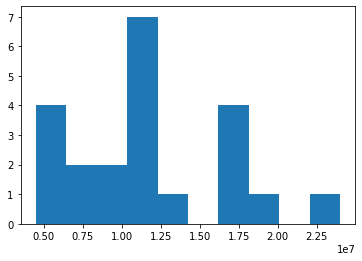

In [227]:
podlazi = plt.hist(NM_sale['Cena:'])
podlazi.show

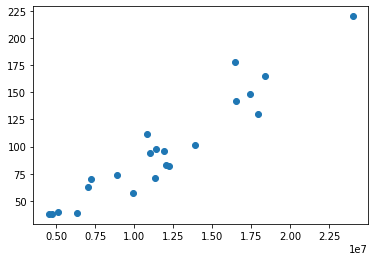

In [225]:
plt.scatter(NM_sale['Cena:'], NM_sale['Plocha:'])

In [229]:
print(NM_sale['Cena:'].describe())

count    2.200000e+01
mean     1.176200e+07
std      5.100236e+06
min      4.500000e+06
25%      7.625000e+06
50%      1.135950e+07
75%      1.581250e+07
max      2.400000e+07
Name: Cena:, dtype: float64
